In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_matches = pd.read_csv('/content/drive/MyDrive/IPL_Matches_2008_2022.csv')
df_balls = pd.read_csv('/content/drive/MyDrive/IPL_Ball_by_Ball_2008_2022.csv')

### Renaming features for analysis

In [6]:
df_matches.columns

Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')

In [7]:
df_matches.columns = ['id','city','date','season','matchnumber','team1','team2','venue',
                      'tosswinner','tossdecision','superover','winningteam','wonby','margin',
                      'method','player_of_match','team1players','team2players','umpire1','umpire2']

In [8]:
df_balls.columns

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam'],
      dtype='object')

In [9]:
df_balls.columns = ['id','inning','over','ballnumber','batter','bowler','non_striker',
                    'extra_type','batsman_run','extras_run','total_runs','non_boundary',
                    'is_wicket', 'player_out','dismissal_kind','fielders_involved','battingteam']

In [10]:
df_matches.head()

,id,city,date,season,matchnumber,team1,team2,venue,tosswinner,tossdecision,superover,winningteam,wonby,margin,method,player_of_match,team1players,team2players,umpire1,umpire2
0,1312200,Ahmedabad,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
1,1312199,Ahmedabad,2022-05-27,2022,Qualifier 2,Royal Challengers Bangalore,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,N,Rajasthan Royals,Wickets,7.0,NaN,JC Buttler,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...",CB Gaffaney,Nitin Menon
2,1312198,Kolkata,2022-05-25,2022,Eliminator,Royal Challengers Bangalore,Lucknow Super Giants,"Eden Gardens, Kolkata",Lucknow Super Giants,field,N,Royal Challengers Bangalore,Runs,14.0,NaN,RM Patidar,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['Q de Kock', 'KL Rahul', 'M Vohra', 'DJ Hooda...",J Madanagopal,MA Gough
3,1312197,Kolkata,2022-05-24,2022,Qualifier 1,Rajasthan Royals,Gujarat Titans,"Eden Gardens, Kolkata",Gujarat Titans,field,N,Gujarat Titans,Wickets,7.0,NaN,DA Miller,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",BNJ Oxenford,VK Sharma
4,1304116,Mumbai,2022-05-22,2022,70,Sunrisers Hyderabad,Punjab Kings,"Wankhede Stadium, Mumbai",Sunrisers Hyderabad,bat,N,Punjab Kings,Wickets,5.0,NaN,Harpreet Brar,"['PK Garg', 'Abhishek Sharma', 'RA Tripathi', ...","['JM Bairstow', 'S Dhawan', 'M Shahrukh Khan',...",AK Chaudhary,NA Patwardhan


In [11]:
df_balls.head()

,id,inning,over,ballnumber,batter,bowler,non_striker,extra_type,batsman_run,extras_run,total_runs,non_boundary,is_wicket,player_out,dismissal_kind,fielders_involved,battingteam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,NaN,1,0,1,0,0,NaN,NaN,NaN,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals


### Function to calculate a batter's all-time stats

In [12]:
def show_battingstats(batter_name):
    batter_stat=df_balls[df_balls['batter']==batter_name]
    bowler_wicket=['caught', 'lbw', 'bowled', 'caught and bowled','stumped','hit wicket']
    batter_run=sum(batter_stat['batsman_run'])
    matches_played=batter_stat.groupby('id').count().shape[0]
    given_out=sum(batter_stat.groupby('id').sum().reset_index(drop=True)['is_wicket'])
    strike_rate=round(100*(batter_run/batter_stat.shape[0]), 2)
    
    print('Batsman Name -',batter_name)
    print('Number of matches -', matches_played)
    print('Runs Scored -',batter_run)
    print('Average -', round(batter_run/given_out, 2))
    print('Strike Rate -',strike_rate)

    print('\n-----------------------------------------------\n')


    plt.figure(figsize=(20,15))
    plt.subplot(2,2,1)
    plt.title('Scoring Patterns', size=15)
    batter_stat['batsman_run'].value_counts().plot.pie(autopct='%.2f%%')

    plt.subplot(1,2,2)
    plt.title('Dismissial Mode', size=15)
    batter_stat['dismissal_kind'].value_counts().plot.pie(autopct='%.2f%%')

    plt.subplot(2,2,3)
    plt.title(f"Top 10 bowler who took {batter_name}'s\n wicket most number of times", size=15)
    batter_stat[batter_stat['dismissal_kind'].isin(bowler_wicket)]['bowler'].value_counts()[:10].plot(kind='bar')
    plt.xlabel('Bowler Name', size=13)
    plt.ylabel('Number of dismissals', size=13)

In [ ]:
show_battingstats('DA Warner')

### Function to calculate a bowler's all-time stats

In [14]:
def show_bowlingstats(bowler_name):
    bowler_wicket_kind=['caught', 'lbw', 'bowled', 'caught and bowled','stumped','hit wicket']
    bowler_delivery=df_balls[df_balls['bowler']==bowler_name]
    bowler_wickets=bowler_delivery[bowler_delivery['dismissal_kind'].isin(bowler_wicket_kind)]

    wickets_taken=sum(bowler_wickets['is_wicket'])
    matches_played=bowler_delivery.groupby('id').count().shape[0]
    balls_bowled=df_balls[df_balls['bowler']==bowler_name].shape[0]
    run_conceded=sum(bowler_delivery['batsman_run'])
    economy=(run_conceded/balls_bowled)*6
    strike_rate=balls_bowled/wickets_taken
    
    print('Bowler Name -',bowler_name)
    print('Number of matches -', matches_played)
    print('Number of balls bowled -', balls_bowled)
    print('Runs Conceded -',run_conceded)
    print('Economy -', round(economy, 2))
    print('Strike Rate -',round(strike_rate,2))

    print('\n-----------------------------------------------\n')

    plt.figure(figsize=(20,15))
    plt.subplot(2,2,1)
    plt.title('Dismissial Kind',size=15)
    bowler_wickets['dismissal_kind'].value_counts().plot.pie(autopct='%.2f%%',startangle=135)
    plt.subplot(2,2,2)
    plt.title(f"Batters {bowler_name} has dismissed most number of times", size=15)
    plt.xlabel('Batter Name', size=13)
    plt.ylabel('Number of times dismissed', size=13)
    bowler_wickets['batter'].value_counts().head(20).plot.bar()

Bowler Name - JD Unadkat
Number of matches - 90
Number of balls bowled - 1942
Runs Conceded - 2729
Economy - 8.43
Strike Rate - 21.34

-----------------------------------------------



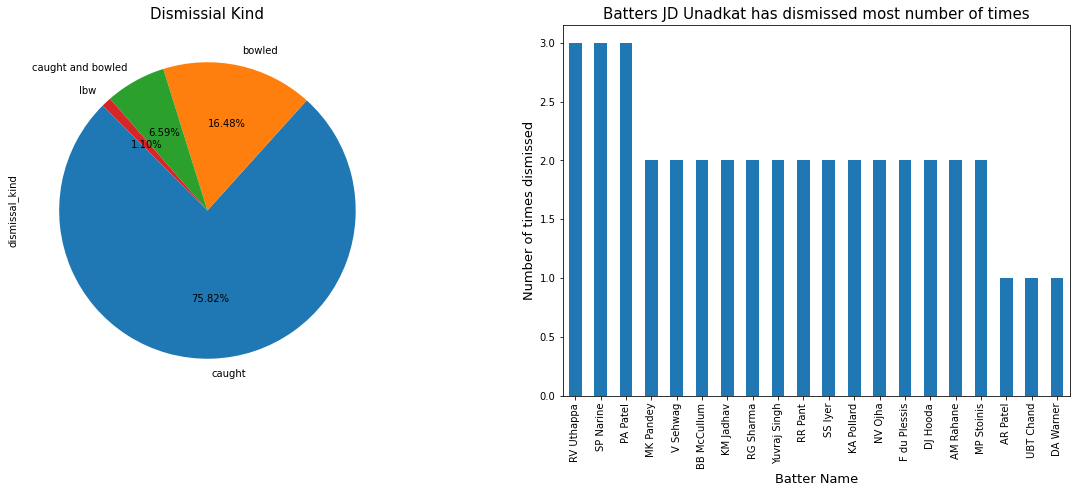

In [40]:
show_bowlingstats('JD Unadkat')

### Head-to-Head Match Ups

In [16]:
def head_to_head(batsman, bowler):
  try:
    batsman_scored=df_balls[(df_balls['batter']==batsman) & (df_balls['bowler']==bowler)].groupby('batter').sum()['total_runs'][0]
    bowler_wickets=df_balls[(df_balls['batter']==batsman) & (df_balls['bowler']==bowler) & (df_balls['is_wicket']==1)].shape[0]
    ball_faced=df_balls[(df_balls['batter']==batsman) & (df_balls['bowler']==bowler)].count()[0]
    NoOfFours=df_balls[(df_balls['batter']==batsman) & (df_balls['bowler']==bowler) & (df_balls['batsman_run']==4)].count()[0]
    NoOfSixes=df_balls[(df_balls['batter']==batsman) & (df_balls['bowler']==bowler) & (df_balls['batsman_run']==6)].count()[0]
    StrikeRate=round((batsman_scored/ball_faced)*100, 2)
    if bowler_wickets==0:
        average='Infinite'
    else:
        average=batsman_scored/bowler_wickets
    d={'Match Up':(batsman +" vs "+ bowler),'Balls':(ball_faced),'Run Scored':(batsman_scored),
      'Dismissals':(bowler_wickets),'Fours':(NoOfFours) ,'Sixes':(NoOfSixes),'Strike Rate':(StrikeRate),'Average':(average)}
    FinalStat=pd.DataFrame(data=d,index=[1])
    display(FinalStat)
  except:
    print('The input names do not exist in data.')

In [41]:
head_to_head('AB de Villiers', 'JD Unadkat')

,Match Up,Balls,Run Scored,Dismissals,Fours,Sixes,Strike Rate,Average
1,AB de Villiers vs JD Unadkat,26,46,0,1,5,176.92,Infinite


### Statistics for last 3 seasons

In [18]:
matches_2022 = list(df_matches['id'].loc[df_matches.season=='2022'])
matches_2021 = list(df_matches['id'].loc[df_matches.season=='2021'])
matches_2020 = list(df_matches['id'].loc[df_matches.season=='2020'])

matches = matches_2022+matches_2021+matches_2020

In [19]:
teams = ['Rajasthan Royals',
         'Royal Challengers Bangalore', 
         'Delhi Capitals', 
         'Mumbai Indians',
         'Chennai Super Kings',
         'Gujarat Titans',
         'Sunrisers Hyderabad',
         'Punjab Kings',
         'Kolkata Knight Riders',
         'Lucknow Super Giants']

players = []

In [20]:
for game in matches:
    team = list(df_matches['team1'].loc[df_matches.id==game])[0]
    XI_team1 = list(df_matches['team1players'].loc[df_matches.id==game])[0]
    XI_team2 = list(df_matches['team1players'].loc[df_matches.id==game])[0]
    listofplayers1 = re.findall(r"'([^']*)'", XI_team1)
    listofplayers2 = re.findall(r"'([^']*)'", XI_team2)
    for i in range(len(listofplayers1)):
        if listofplayers1[i] not in players:
            players.append(listofplayers1[i])
        else:
            continue
            
    for i in range(len(listofplayers2)):
        if listofplayers2[i] not in players:
            players.append(listofplayers2[i])
        else:
            continue

In [21]:
players=sorted(players)

In [22]:
#mydict = {i:players.count(i) for i in players}
#mydict

#### Preprocessing for season-by-season performance of batters

In [23]:
match_data = df_matches
ball_data = df_balls

ball_data['bowlingteam'] = ''
ball_data['first_batter'] = ''
ball_data['second_batter'] = ''

In [24]:
ball_data = pd.merge(ball_data, match_data[['id','team1','team2','season']], how='left', on='id')
ball_data['bowlingteam'] = ball_data.apply(lambda x: x['team2'] if x['battingteam'] == x['team1'] else x['team1'], axis=1)

In [25]:
match_data['win_against'] = match_data.apply(lambda x: x['team2'] if x['winningteam'] == x['team1'] else x['team1'], axis=1)

### Season-by-season performance analysis of batters

In [26]:
# Performance across seasons
def performance(batter):
  try :
    top_batsman=[batter]
    top_batsman_runs=ball_data[ball_data['batter'].isin(top_batsman)].groupby(['season','batter'])\
        .agg(batsman_total=('batsman_run', 'sum')).reset_index()\
        .sort_values(by=['season','batsman_total'], ascending=False)
    top_batsman_runs=top_batsman_runs.pivot_table('batsman_total', ['season'], 'batter').reset_index()

    plt.figure(figsize=(15,8))
    plt.plot(top_batsman_runs['season'], top_batsman_runs[batter], label = batter, linewidth=4, color='red')
    plt.xlabel("Season", fontsize=13) 
    plt.ylabel("Runs", fontsize=13)
    plt.title("Batter's Performance across seasons", fontsize=15) 
    plt.legend()
    plt.show()

  except:
    return "Please enter a valid name."

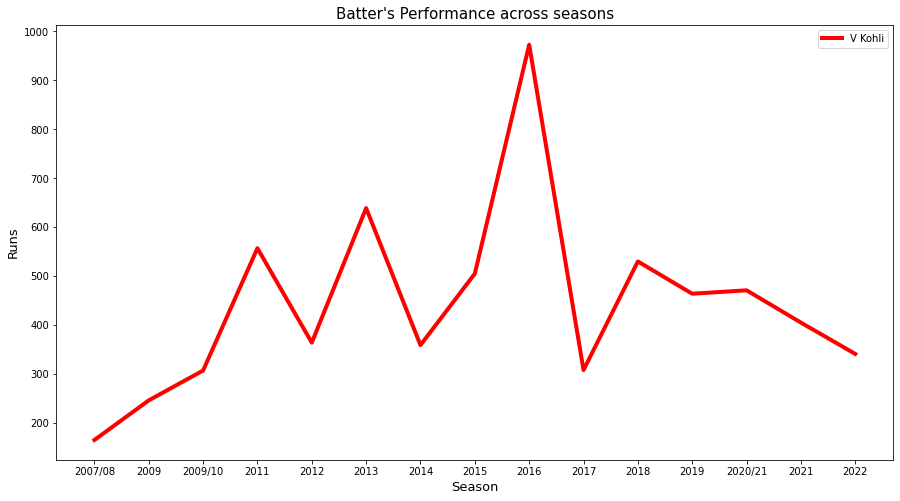

In [42]:
performance('V Kohli')

### All-time statistical analysis of players who featured in last 3 seasons

#### All-time statistics of players

In [28]:
def stats(players):
    data=[]
    for player in players:
        batter_stat=df_balls[df_balls['batter']==player]
        bowler_wicket=['caught', 'lbw', 'bowled', 'caught and bowled','stumped','hit wicket']
        batter_run=sum(batter_stat['batsman_run'])
        matches_played_batting=batter_stat.groupby('id').count().shape[0]
        given_out=sum(batter_stat.groupby('id').sum().reset_index(drop=True)['is_wicket'])
        
        try:
            strike_rate_batting=round(100*(batter_run/batter_stat.shape[0]), 2)
            average_batting = round(batter_run/given_out, 2)
            
            
        except:
            strike_rate_batting = None
            average_batting = None
        
        try:
            bowler_wicket_kind=['caught', 'lbw', 'bowled', 'caught and bowled','stumped','hit wicket']
            bowler_delivery=df_balls[df_balls['bowler']==player]
            bowler_wickets=bowler_delivery[bowler_delivery['dismissal_kind'].isin(bowler_wicket_kind)]
            wickets_taken=sum(bowler_wickets['is_wicket'])
            matches_played_bowling=bowler_delivery.groupby('id').count().shape[0]
            balls_bowled=df_balls[df_balls['bowler']==player].shape[0]
            runs_conceded=sum(bowler_delivery['batsman_run'])
            economy=round((runs_conceded/balls_bowled)*6, 2)
            strike_rate_bowling=round(balls_bowled/wickets_taken, 2)
            average_bowling=round(runs_conceded/wickets_taken, 2)

        except:
            matches_played_bowling = None
            wickets_taken = None
            balls_bowled = None
            runs_conceded = None
            economy = None
            average_bowling = None
            strike_rate_bowling=  None
   
        '''print('Batsman Name -',player)
        print('Number of matches -', matches_played_batting)
        print('Runs Scored -',batter_run)
        print('Average -', average_batting)
        print('Strike Rate -',strike_rate_batting)

        print('\n-----------------------------------------------\n')
        
        print('Number of matches bowled in -', matches_played_bowling)
        print('Wickets taken -', wickets_taken)
        print('Number of balls bowled -', balls_bowled)
        print('Runs Conceded -',runs_conceded)
        print('Economy -', economy)
        print('Average - ', average_bowling)
        print('Strike Rate -',strike_rate_bowling)'''
        
        row = [player, matches_played_batting, batter_run, average_batting, strike_rate_batting,
              matches_played_bowling, wickets_taken, balls_bowled, runs_conceded, economy, average_bowling, strike_rate_bowling]
        
        data.append(row)

        '''print('\n-----------------------------------------------')
        print('-----------------------------------------------\n')'''

    stats_df = pd.DataFrame(data, columns = ['player',
                                         'matches_played_batting',
                                         'batter_run', 
                                         'average_batting',
                                         'strike_rate_batting',
                                         'matches_played_bowling', 
                                         'wickets_taken',
                                         'balls_bowled',
                                         'runs_conceded',
                                         'economy',
                                         'average_bowling', 
                                         'strike_rate_bowling'])
    
    return stats_df

In [29]:
stats_df = stats(players)
stats_df

,player,matches_played_batting,batter_run,average_batting,strike_rate_batting,matches_played_bowling,wickets_taken,balls_bowled,runs_conceded,economy,average_bowling,strike_rate_bowling
0,A Badoni,11,161,17.89,115.83,2.0,2.0,12.0,11.0,5.50,5.50,6.00
1,A Manohar,7,108,18.00,136.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A Mishra,54,362,12.07,88.29,154.0,166.0,3317.0,3897.0,7.05,23.48,19.98
3,A Nortje,4,8,8.00,61.54,30.0,43.0,706.0,884.0,7.51,20.56,16.42
4,AB de Villiers,170,5181,41.45,148.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
207,WP Saha,117,2427,25.28,124.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,Washington Sundar,32,318,13.83,114.39,49.0,33.0,928.0,1090.0,7.05,33.03,28.12
209,YBK Jaiswal,23,547,23.78,133.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,YS Chahal,17,37,6.17,41.57,130.0,166.0,2940.0,3524.0,7.19,21.23,17.71


#### Power Hitters segregation

In [30]:
def get_power_hitters(df):
  power_hitters = df.loc[df.strike_rate_batting>140].loc[df.matches_played_batting>=5]
  power_hitters = power_hitters.reset_index()
  power_hitters.drop('index',axis=1, inplace=True)
  return power_hitters

#### Anchor batters segregation

In [31]:
def get_anchors(df):
  anchors = df.loc[(df.strike_rate_batting>=110) & (df.strike_rate_batting<=140)].loc[df.matches_played_batting>=5]
  anchors = anchors.reset_index()
  anchors.drop('index',axis=1, inplace=True)
  return anchors

In [32]:
power_hitters = get_power_hitters(stats_df)
power_hitters

,player,matches_played_batting,batter_run,average_batting,strike_rate_batting,matches_played_bowling,wickets_taken,balls_bowled,runs_conceded,economy,average_bowling,strike_rate_bowling
0,AB de Villiers,170,5181,41.45,148.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AD Russell,81,2039,30.89,168.23,89.0,89.0,1484.0,2114.0,8.55,23.75,16.67
2,Avesh Khan,6,31,31.00,163.16,38.0,47.0,868.0,1124.0,7.77,23.91,18.47
3,CH Gayle,141,4997,39.04,142.12,38.0,18.0,584.0,680.0,6.99,37.78,32.44
4,CH Morris,49,618,21.31,149.64,81.0,96.0,1801.0,2220.0,7.40,23.12,18.76
5,D Pretorius,5,44,11.00,157.14,6.0,6.0,138.0,198.0,8.61,33.00,23.00
6,DP Conway,7,252,42.00,143.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GJ Maxwell,105,2320,25.78,147.68,66.0,28.0,803.0,1060.0,7.92,37.86,28.68
8,HH Pandya,100,1972,29.88,140.26,70.0,50.0,1103.0,1484.0,8.07,29.68,22.06
9,JC Buttler,81,2832,39.89,144.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
anchors = get_anchors(stats_df)
anchors

,player,matches_played_batting,batter_run,average_batting,strike_rate_batting,matches_played_bowling,wickets_taken,balls_bowled,runs_conceded,economy,average_bowling,strike_rate_bowling
0,A Badoni,11,161,17.89,115.83,2.0,2.0,12.0,11.0,5.50,5.50,6.00
1,A Manohar,7,108,18.00,136.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AJ Finch,90,2092,24.90,123.35,5.0,1.0,44.0,66.0,9.00,66.00,44.00
3,AJ Tye,13,91,11.38,115.19,30.0,42.0,714.0,949.0,7.97,22.60,17.00
4,AK Markram,18,527,40.54,131.75,6.0,1.0,61.0,86.0,8.46,86.00,61.00
...,...,...,...,...,...,...,...,...,...,...,...,...
84,V Shankar,41,731,24.37,118.67,22.0,9.0,258.0,323.0,7.51,35.89,28.67
85,VR Iyer,22,552,27.60,116.46,8.0,3.0,78.0,112.0,8.62,37.33,26.00
86,WP Saha,117,2427,25.28,124.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Washington Sundar,32,318,13.83,114.39,49.0,33.0,928.0,1090.0,7.05,33.03,28.12


### Recent statistics of players who featured in last 3 seasons

In [34]:
print(max(matches), min(matches))

1312200 1254058


In [35]:
recent_matches = df_balls.loc[(df_balls.id<=1312200) & (df_balls.id>=1254058)]

#### Recent statistics of players

In [36]:
def recent_stats(players):
    recent_data=[]
    for player in players:
        batter_stat=recent_matches[recent_matches['batter']==player]
        bowler_wicket=['caught', 'lbw', 'bowled', 'caught and bowled','stumped','hit wicket']
        batter_run=sum(batter_stat['batsman_run'])
        matches_played_batting=batter_stat.groupby('id').count().shape[0]
        given_out=sum(batter_stat.groupby('id').sum().reset_index(drop=True)['is_wicket'])
        
        try:
            strike_rate_batting=round(100*(batter_run/batter_stat.shape[0]), 2)
            average_batting = round(batter_run/given_out, 2)
            
            
        except:
            strike_rate_batting = None
            average_batting = None
        
        try:
            bowler_wicket_kind=['caught', 'lbw', 'bowled', 'caught and bowled','stumped','hit wicket']
            bowler_delivery=recent_matches[recent_matches['bowler']==player]
            bowler_wickets=bowler_delivery[bowler_delivery['dismissal_kind'].isin(bowler_wicket_kind)]
            wickets_taken=sum(bowler_wickets['is_wicket'])
            matches_played_bowling=bowler_delivery.groupby('id').count().shape[0]
            balls_bowled=recent_matches[recent_matches['bowler']==player].shape[0]
            runs_conceded=sum(bowler_delivery['batsman_run'])
            economy=round((runs_conceded/balls_bowled)*6, 2)
            strike_rate_bowling=round(balls_bowled/wickets_taken, 2)
            average_bowling=round(runs_conceded/wickets_taken, 2)

        except:
            matches_played_bowling = None
            wickets_taken = None
            balls_bowled = None
            runs_conceded = None
            economy = None
            average_bowling = None
            strike_rate_bowling=  None
        
        row = [player, matches_played_batting, batter_run, average_batting, strike_rate_batting,
              matches_played_bowling, wickets_taken, balls_bowled, runs_conceded, economy, average_bowling, strike_rate_bowling]
        
        recent_data.append(row)

        
    recent_stats_df = pd.DataFrame(recent_data, columns = ['player',
                                         'matches_played_batting',
                                         'batter_run', 
                                         'average_batting',
                                         'strike_rate_batting',
                                         'matches_played_bowling', 
                                         'wickets_taken',
                                         'balls_bowled',
                                         'runs_conceded',
                                         'economy',
                                         'average_bowling', 
                                         'strike_rate_bowling'])
    
    return recent_stats_df

In [37]:
recent_stats_df = recent_stats(players)
recent_stats_df.head()

,player,matches_played_batting,batter_run,average_batting,strike_rate_batting,matches_played_bowling,wickets_taken,balls_bowled,runs_conceded,economy,average_bowling,strike_rate_bowling
0,A Badoni,11,161,17.89,115.83,2.0,2.0,12.0,11.0,5.50,5.50,6.00
1,A Manohar,7,108,18.00,136.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A Mishra,0,0,NaN,NaN,4.0,6.0,84.0,109.0,7.79,18.17,14.00
3,A Nortje,1,1,NaN,NaN,14.0,21.0,330.0,382.0,6.95,18.19,15.71
4,AB de Villiers,14,313,28.45,145.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Power Hitters segregation

In [38]:
power_hitters_recent = get_power_hitters(recent_stats_df)
power_hitters_recent

,player,matches_played_batting,batter_run,average_batting,strike_rate_batting,matches_played_bowling,wickets_taken,balls_bowled,runs_conceded,economy,average_bowling,strike_rate_bowling
0,AB de Villiers,14,313,28.45,145.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AD Russell,20,518,34.53,158.41,21.0,28.0,298.0,447.0,9.00,15.96,10.64
2,Avesh Khan,5,27,27.00,168.75,29.0,42.0,683.0,830.0,7.29,19.76,16.26
3,D Pretorius,5,44,11.00,157.14,6.0,6.0,138.0,198.0,8.61,33.00,23.00
4,DJ Bravo,9,70,17.50,145.83,21.0,30.0,450.0,519.0,6.92,17.30,15.00
5,DP Conway,7,252,42.00,143.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,E Lewis,10,224,28.00,143.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GJ Maxwell,27,814,38.76,146.14,16.0,9.0,245.0,295.0,7.22,32.78,27.22
8,JC Buttler,24,1117,50.77,145.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,JD Unadkat,8,100,33.33,144.93,11.0,10.0,257.0,352.0,8.22,35.20,25.70


#### Anchor batters segregation

In [39]:
anchors = get_anchors(recent_stats_df)
anchors

,player,matches_played_batting,batter_run,average_batting,strike_rate_batting,matches_played_bowling,wickets_taken,balls_bowled,runs_conceded,economy,average_bowling,strike_rate_bowling
0,A Badoni,11,161,17.89,115.83,2.0,2.0,12.0,11.0,5.50,5.50,6.00
1,A Manohar,7,108,18.00,136.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AJ Finch,5,86,14.33,122.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AK Markram,18,527,40.54,131.75,6.0,1.0,61.0,86.0,8.46,86.00,61.00
4,AR Patel,16,222,27.75,127.59,25.0,21.0,546.0,626.0,6.88,29.81,26.00
...,...,...,...,...,...,...,...,...,...,...,...,...
64,Tilak Varma,14,397,39.70,126.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,UT Yadav,7,55,13.75,134.15,12.0,16.0,297.0,330.0,6.67,20.62,18.56
66,V Kohli,31,746,24.87,114.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,VR Iyer,22,552,27.60,116.46,8.0,3.0,78.0,112.0,8.62,37.33,26.00
